In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt


import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
ITERATIONS = 20 # Number of iterations
IMAGE_WIDTH = 512 # 512x512 is fine for HD images
IMAGE_HEIGHT = 512
CONTENT_WEIGHT = 1 # Weight of the content loss
STYLE_WEIGHT = 0.01 # Weight og the style loss
TOTAL_VARIATION_WEIGHT = 15 # Weight of the total variation loss
INPUT_IMAGE = 'noise' # Can be : 'noise', 'content', 'style', or a path to a file.

In [4]:
content_layers = ['conv_1', 'conv_2', 'conv_4']
style_layers = ['conv_2', 'conv_3', 'conv_4', 'conv_7', 'conv_10', 'conv_8']

In [5]:
content_image_path = "/content/content.png"
style_image_path = "/content/style.png"
output_image_path = "/content/result.png"
combined_image_path = "/content/combined.png"

##**Image Selection**

In [7]:
# Content images


dog = "https://raw.githubusercontent.com/gaganbahga/cosine_art/master/test_images/test_image_2.jpg"

# Style images:
colorswir = "https://paintings.pinotspalette.com/colorful-swirly-sky-tv.jpg?v=10026315"


# The function wich allow us to download / open an image
def open_image(url):
  if url.startswith("http"):
    return Image.open(BytesIO(requests.get(url).content))
  else:
    return Image.open(url)

In [8]:
content_url = dog
style_url = colorswir

##**Load Image**

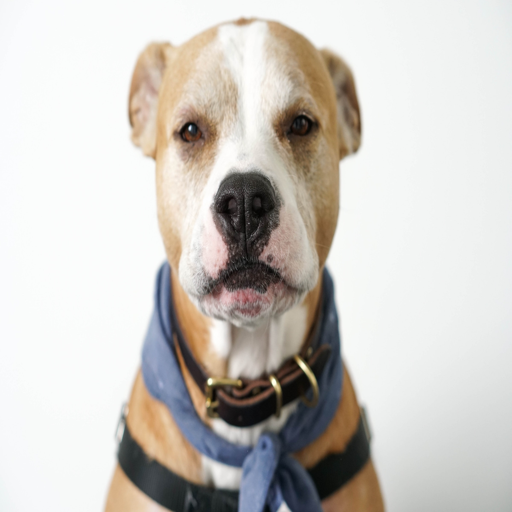

In [9]:
#title This is the _content_ image
content_image = open_image(content_url)
content_image = content_image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
content_image.save(content_image_path)
content_image

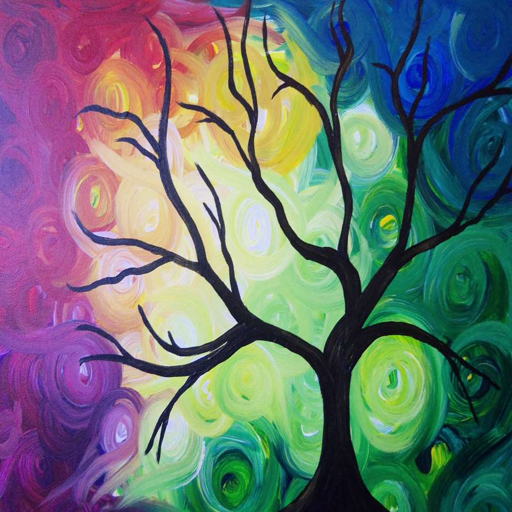

In [10]:
#title This is the _style_ image
style_image = open_image(style_url)
style_image = style_image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
style_image.save(style_image_path)
style_image

##**Model Building**

In [11]:
class ContentLoss(nn.Module):
  def __init__(self, target,):
    super(ContentLoss, self).__init__()

    self.target = target.detach()

  def forward(self, input):
    self.loss = F.mse_loss(input, self.target)
    return input

In [12]:
class StyleLoss(nn.Module):
  def __init__(self, target_feature):
    super(StyleLoss, self).__init__()
    self.target = self.gram_matrix(target_feature).detach()

  def forward(self, input):
    G = self.gram_matrix(input)
    self.loss = F.mse_loss(G, self.target)
    return input

  @staticmethod
  def gram_matrix(input):
    a, b, c, d = input.size()
    features = input.view(a * b, c * d)

    # Compute the gram product
    G = torch.mm(features, features.t())
    return G.div((a * b * c * d) ** 0.5)

In [13]:
def total_variation_loss(x): # Expect a mini batch of dim NxWxH
  image_height = x.shape[1]
  image_width = x.shape[2]
  dx = x[:, :image_height-1, :image_width-1, :] - x[:, 1:, :image_width-1, :]
  dy = x[:, :image_height-1, :image_width-1, :] - x[:, :image_height-1, 1:, :]
  loss = (dx ** 2 + dy ** 2).sum() ** 0.5
  # Return loss normalized by image and batch size
  return loss / (image_width * image_height * x.shape[0])

In [14]:
class Normalization(nn.Module):
  def __init__(self, mean, std):
    super(Normalization, self).__init__()
    self.mean = torch.tensor(mean).view(-1, 1, 1)
    self.std = torch.tensor(std).view(-1, 1, 1)

  def forward(self, img):
    # Normalize img
    return (img - self.mean) / self.std

##**Download & Build VGG19**

In [15]:
# Neural network used.
cnn = models.vgg19(pretrained=True).features.to(device).eval()

# Normalization mean and standard deviation.
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:10<00:00, 54.3MB/s]


In [16]:
def get_model_and_losses(style_img, content_img,
                               cnn=cnn,
                               cnn_normalization_mean=cnn_normalization_mean,
                               cnn_normalization_std=cnn_normalization_std):
  # Make a deep copy of vgg19 in order to not modify the original
  cnn = copy.deepcopy(cnn)

  # Normalization module
  normalization = Normalization(cnn_normalization_mean, cnn_normalization_std).to(device)

  # This list will contain the losses computed by the network.
  content_losses = []
  style_losses = []

  # Normalization layer.
  model = nn.Sequential(normalization)

  i = 0  # Incremented every time we see a conv layer.
  for layer in cnn.children():

    if isinstance(layer, nn.Conv2d):
        i += 1
        name = 'conv_{}'.format(i)
    elif isinstance(layer, nn.ReLU):
        name = 'relu_{}'.format(i)
        layer = nn.ReLU(inplace=False)
    elif isinstance(layer, nn.MaxPool2d):
        name = 'pool_{}'.format(i)
    elif isinstance(layer, nn.BatchNorm2d):
        name = 'bn_{}'.format(i)
    else:
        raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

    model.add_module(name, layer)

    if name in content_layers:
      target = model(content_img).detach()
      content_loss = ContentLoss(target)
      model.add_module("content_loss_{}".format(i), content_loss)
      content_losses.append(content_loss)

    if name in style_layers:
      target_feature = model(style_img).detach()
      style_loss = StyleLoss(target_feature)
      model.add_module("style_loss_{}".format(i), style_loss)
      style_losses.append(style_loss)


  for i in range(len(model) - 1, -1, -1):
      if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
          break

  model = model[:(i + 1)]

  return model, style_losses, content_losses

In [17]:
def image_to_tensor(image):
  # Transform to tensor
  image = transforms.ToTensor()(image)
  # Fake batch dimension required to fit network's input dimensions
  image = image.unsqueeze(0)
  # Move to the right device and convert to float
  return image.to(device, torch.float)

content_img = image_to_tensor(content_image)
style_img = image_to_tensor(style_image)

In [18]:
# Reconvert a tensor into PIL image
def tensor_to_image(tensor):
  img = (255 * tensor).cpu().detach().squeeze(0).numpy()
  img = img.clip(0, 255).transpose(1, 2, 0).astype("uint8")
  return Image.fromarray(img)

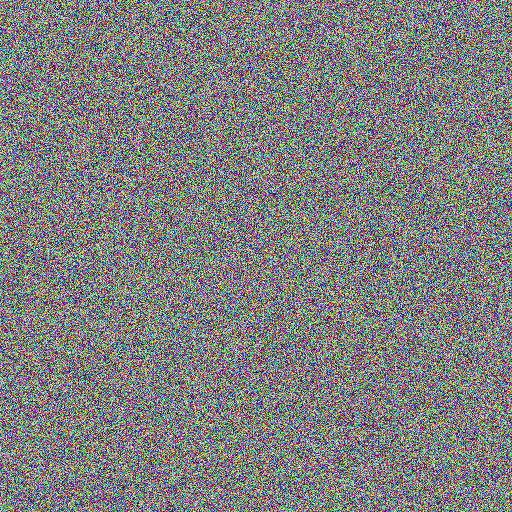

In [19]:
#@title This is the _input_ image
if INPUT_IMAGE == 'noise':
  input_img = torch.randn(content_img.data.size(), device=device)
elif INPUT_IMAGE == 'content':
  input_img = content_img.clone()
elif INPUT_IMAGE == 'style':
  input_img = style_img.clone()
else:
  image = open_image(INPUT_IMAGE).resize((IMAGE_SIZE, IMAGE_SIZE))
  input_img = image_to_tensor(image)
  input_img += torch.randn(content_img.data.size(), device=device)*0.1

if INPUT_IMAGE == 'noise':
  img = transforms.ToPILImage()(input_img[0].cpu())
else:
  img = tensor_to_image(input_img[0])
img

In [25]:
def get_input_optimizer(input_img):
  # This line tell LBFGS what parameters we should optimize
  optimizer = optim.LBFGS([input_img.requires_grad_()])
  #optimizer = optim.Adam([input_img.requires_grad_()])
  return optimizer

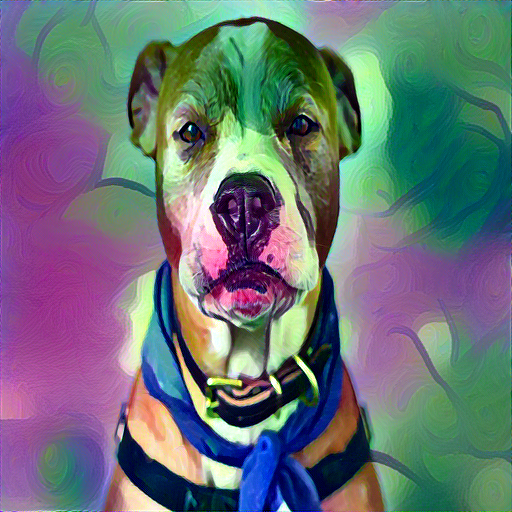

In [26]:
#title result
img = tensor_to_image(input_img)
img.save(output_image_path)
img

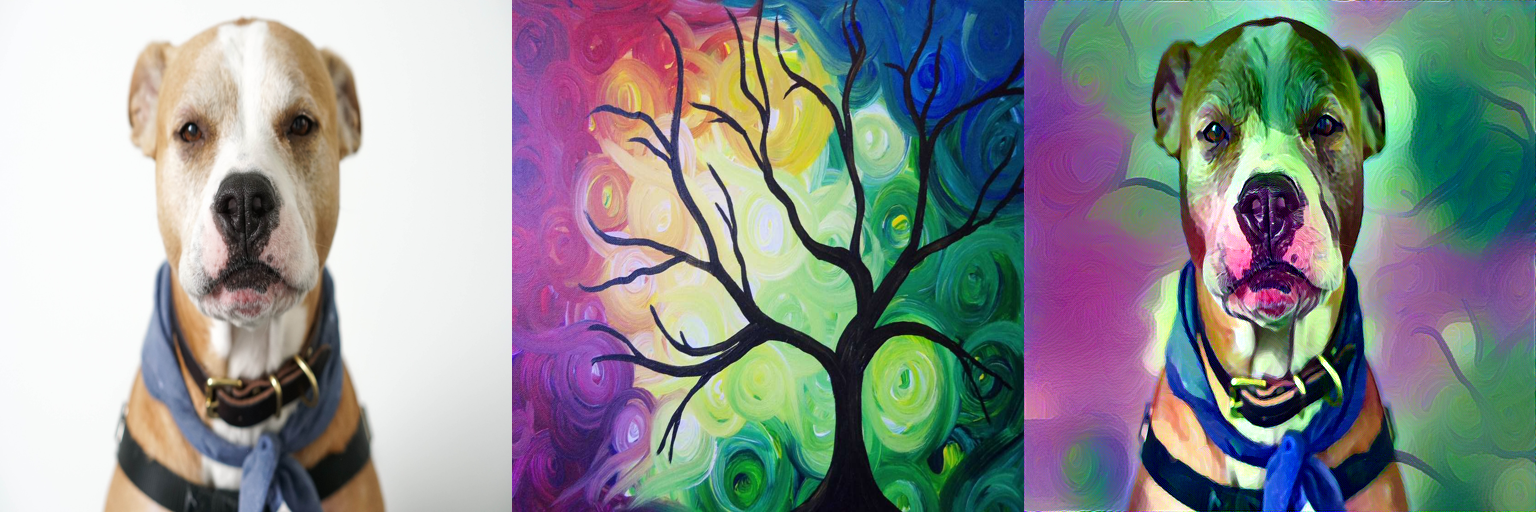

In [27]:
combined = Image.new("RGB", (IMAGE_WIDTH*3, IMAGE_HEIGHT))
x_offset = 0
for image in map(Image.open, [content_image_path, style_image_path, output_image_path]):
    combined.paste(image, (x_offset, 0))
    x_offset += IMAGE_WIDTH
combined.save(combined_image_path)
combined